# SIR

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Fri Apr  3 17:27:59 2020


In [4]:
import numpy as np
import pandas as pd
import matplotlib

In [5]:
fontsize=20
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': fontsize,
        }

plt.rcParams["font.size"     ] = fontsize


In [6]:
from scipy.integrate import odeint
import scipy.integrate as spi
from scipy.interpolate import interp1d


In [7]:
from dataclasses import dataclass, field

In [8]:
from c19.types import SIR, SEIR

In [9]:
import c19.basic_models as cbm
import c19.core_functions as cf
import c19.plotting as cplt
import c19.utils as ut

In [10]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# The SIR model

- A simple mathematical description of the spread of a disease in a population is the so-called SIR model, which divides the (fixed) population of N individuals into three "compartments" which may vary as a function of time, t:

- $S(t)$ are those susceptible but not yet infected with the disease;
- $I(t)$ is the number of infectious individuals;
- $R(t)$ are those individuals who have recovered from the disease and now have immunity to it.

-The SIR model describes the change in the population of each of these compartments in terms of two parameters, $\beta$ and $\gamma$. 
β describes the effective contact rate of the disease: an infected individual comes into contact with βN other individuals per unit time (of which the fraction that are susceptible to contracting the disease is S/N). γ is the mean recovery rate: that is, 1/γ
is the mean period of time during which an infected individual can pass it on.

-The differential equations describing this model were first derived by Kermack and McKendrick [Proc. R. Soc. A, 115, 772 (1927)]:

$$
\frac{dS}{dt} = - \frac{\beta S I}{N} \\
\frac{dI}{dt} = \frac{\beta S I}{N} - \gamma I \\
\frac{dR}{dt} = \gamma R
$$

If we express I, S and R in terms of relative fractions (with respect to N) the equations are: 

$$
\frac{dS}{dt} = - \beta S I \\
\frac{dI}{dt} = \beta S I - \gamma I \\
\frac{dR}{dt} = \gamma R
$$

In the interactive tool, the user can play with two parameters:

- $R_0$, which is defined as the mean propagation rate of the disease. It turns out that $R_0 = \frac{\beta}{\gamma}$. $R_0$ is readily understood as the mean number of persons that can contract the disease on encounter with an infected person.

- $ T =\frac{1}{\gamma}$ which is the time that an individual can infect others. After that period the individual "recovers". 

- Notice that the SIR model does not distinguish between people who truly recovers and people who dies. Both of them count as "recovered". Also, notice that the real time that an ill person may take to truly recover (or die) may be much longer (tipically 2-3 weeks), but the person stops being infectious after $T$.

- Experiment changing the value of $R_0$ and T. As $R_0$ becomes smaller we "flatten the curve". Notice that the peak of the infection is lower but also it arrives later. Same thing occurs if you make T longer.

- In practice, the social distancing measures reduce $R_0$ from its "intrinsic value" (if nothing is done) to lower values. As $R_0$ becomes smaller the peak of the curve arrives later not sooner (as the naive expectation would have). But if $R_0$ drops below one, the epidemy stops. It is thus possible to abort the epidemy if one manages to reduce $R_0$ sufficiently. However, if the measures are relaxed $R_0$ may grow again towards its intrinsic value and the epidemics springs again. 



## Example

1. N = 47 M, Spain population. 

2. Take COVID deault parameters as: R0 =3.5, T = 5 days 

In [17]:
N                = 4.7e+7
ND               = 200
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
RX, Gamma        = 3.5, 1./5 
Beta             = Gamma * RX
I0               = 1E-5
S0               = 1 - I0
R0               = 0
Y0               = (S0, I0, R0)


In [18]:
sir = cbm.compute_sir(N, Y0, RX, Gamma, t_range, ts = [(0, ND)], ms=[1.0]) 

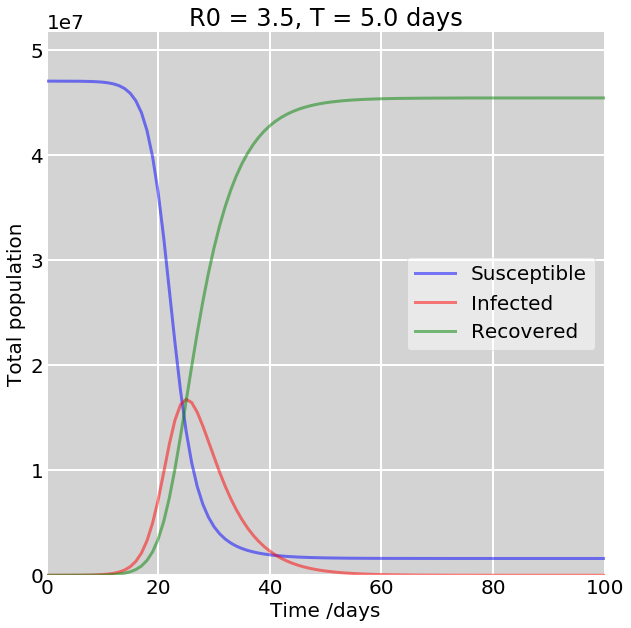

In [19]:
cplt.plot_sir(sir, f"R0 = {RX}, T = {1/Gamma} days", absolute=True,
             tmin = 0, tmax = 100, figsize=(10,10))

# Interactive example

In [35]:
def sir_deriv(y, t, M, beta, gamma):
    """Prepares the SIR system of equations"""
    S, I, R = y
    dSdt = -beta * M(t) * S * I
    dIdt = beta * M(t) * S * I - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


In [36]:
def mitigation_function(t, ts = [(0, 400)], ms=[1]):
    """Defines a mitigation function as follows:
    1) the time of the infection, t, is divided in tranches specified by ts. Thus, for example,
    ts =[(0,20), (20,60), (60,100)] would divide a time vector of 100 days in 3 tranches,
    the first one
    from day 0 to day 20 and so on.
    2) ms corresponds to the mitigation factor in each tranch. Thus, [(1, 0.5, 0.8)] in the
    example would
    mean that the first tranch no mitigation is applied (R0 * 1), and for second and third
    tranches the
    mitigation would be (R0 * 0.5) and (R0 * 0.8)
    """
    def mitigation(t, ts, ms):
        lt = len(t)
        lm = len(ms)
        x = int(lt /lm)
        c = np.ones(lt)
        for i, tsi in enumerate(ts):
            c[tsi[0]:tsi[1]] = ms[i]
        c[-1] = ms[-1]
        return c

    C = mitigation(t, ts, ms)
    M = interp1d(t, C, bounds_error=False, fill_value="extrapolate")
    return M


In [37]:
def set_pretty_ax(ax, facecolor, xlabel, ylabel, xmin, xmax, ymax):
    ax.set_facecolor(facecolor)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(0,ymax)
    ax.set_xlim(xmin,xmax)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)


In [43]:
figsize=(10,10)
facecolor='LightGrey'
@interact
def plint_sir(T=5., R0=3.5, t0 = 0, tf = 200, m = 1.0, absolute=True):
    """interactive SIR"""
    
    Gamma = 1/T
    Beta  = Gamma * R0
    ts =[(t0, tf)]
    ms = [m]
    M = mitigation_function(t_range, ts, ms)
    ret = odeint(sir_deriv, Y0, t_range, args=(M, Beta, Gamma))
    S, I, R = ret.T

    sir = SIR(N = N, S=S, I=I,  R=R,
              beta=Beta, R0=R0, gamma=Gamma,  t= t_range)
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, axisbelow=True)
    ax.set_facecolor(facecolor)

    if absolute:
        S = sir.S * sir.N
        I = sir.I * sir.N
        R = sir.R * sir.N
        Y = 1.1 * sir.N
    else:
        S = sir.S
        I = sir.I
        R = sir.R
        Y = 1.1

    ax.plot(sir.t, S, 'b', alpha=0.5, lw=3, label='Susceptible')
    ax.plot(sir.t, I, 'r', alpha=0.5, lw=3, label='Infected')
    ax.plot(sir.t, R, 'g', alpha=0.5, lw=3, label='Recovered')
    xlabel = 'Time /days'
    if absolute:
        ylabel = 'Total population'
    else:
        ylabel = 'Fraction of population'

    set_pretty_ax(ax, facecolor, xlabel, ylabel, t0, tf, Y)
    title=f"R0 = {R0}, T = {T}"
    plt.title(title)
    plt.show()


    #return sir


interactive(children=(FloatSlider(value=5.0, description='T', max=15.0, min=-5.0), FloatSlider(value=3.5, desc…